In [3]:
from typing import TypedDict, Optional, List, Dict 

class AgentState(TypedDict):
    question: str
    result : List[Dict]
    selected_index: Optional[int]
    deep_summary: Optional[str]
    feedback: str
    history: List[int]  # 이전에 본 것들 추적
    
    


In [4]:
from langchain.tools import tool

In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()

# os.environ["TAVILY_API_KEY"]
# os.environ["GOOGLE_API_KEY"]
# os.environ["OPENAI_API_KEY"]

True

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults()

In [1]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from typing import List
from langchain_community.tools.tavily_search import TavilySearchResults

import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# Tavily tool (실제 API 키 필요)
tavily_tool = TavilySearchResults(k=5)

class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  
    sender: Annotated[str, "The sender of the last message"] 
    user_feedback: str
    
# OpenAI 모델
# researcher = ChatOpenAI(model="gpt-4o-2024-11-20")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )
    
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "당신은 검색을 통해 내용을 정리해주는 전문적인 리서치 엔지니어 입니다. 들어오는 데이터를 기반으로 내용을 정리해야합니다."
        "내용은 제목, 서론, 본론 등으로 나누어 정리해주세요."
    ),
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": [last_message],
        "user_feedback": "",  # 피드백은 다음 노드에서 받음
    }


In [3]:
def user_feedback_node(state: AgentState) -> AgentState:
    # 실제 서비스에서는 여기에 사용자 입력을 받는 로직 추가
    print("유저에게 보여줄 메시지:", state["messages"][-1].content)
    
    # 지금은 시뮬레이션 (ex: "심화 정리" or "그대로 좋아요")
    feedback = input()  # 여기에 따라 분기 처리

    return {
        **state,
        "user_feedback": feedback,
        "sender": "user"
    }


In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# 워크플로우 정의
workflow = StateGraph(AgentState)

# 노드 등록
workflow.add_node("researcher", research_node)
workflow.add_node("user_feedbacks", user_feedback_node)

# 흐름 연결
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "user_feedbacks")
workflow.add_edge("user_feedbacks", END)

# 워크플로우 컴파일 (researcher 실행 후 중단 설정)
app = workflow.compile(
    checkpointer=MemorySaver(),
    interrupt_after=["researcher"]
)

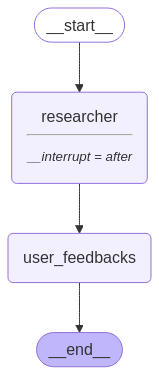

In [25]:
app

In [47]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = {
    "messages": [
        HumanMessage(
            content="김수현 관련 내용 검색해서 정리해줘 "
        )
    ],
}

In [48]:
# researcher 노드까지 실행한 뒤 중지 (interrupt_after로 설정된 researcher까지)
ss = app.invoke(inputs, config={"configurable": {"thread_id": "test_thread"}})

In [49]:
ss

{'messages': [HumanMessage(content='김수현 관련 내용 검색해서 정리해줘 ', additional_kwargs={}, response_metadata={}, id='43b47727-a47e-4371-93ae-5fc71e444ae7'),
  HumanMessage(content="## 김수현 관련 내용 정리\n\n### 제목: 배우 김수현\n\n### 서론\n\n김수현은 대한민국의 유명 배우로, 드라마와 영화에서 다양한 역할을 소화하며 뛰어난 연기력으로 인정받고 있습니다. 높은 출연료를 받는 배우 중 한 명이며, 백상예술대상, 대종상 영화제, 청룡영화상 등 다수의 상을 수상한 경력이 있습니다. 또한, 포브스 파워 셀러브리티 40인 및 30세 이하 아시아 30인에 선정되었으며, 갤럽코리아 올해의 탤런트로 뽑히기도 했습니다.\n\n### 본론\n\n* **출생 및 성장**: 1988년 2월 16일 서울에서 태어났으며, 내성적인 성격을 극복하기 위해 어머니의 권유로 연극을 시작하게 되었습니다. 고등학교 시절부터 연기에 대한 열정을 보였으며, 꾸준히 연습하며 배우의 꿈을 키웠습니다. 아버지는 록밴드 세븐돌핀스의 보컬 김충훈입니다.\n\n* **데뷔 및 활동**: 2007년 MBC 시트콤 '김치 치즈 스마일'로 데뷔하여, 이후 드라마 '해를 품은 달', '별에서 온 그대', '프로듀사', '사이코지만 괜찮아', '어느 날' 등 다수의 작품에서 주연을 맡아 큰 인기를 얻었습니다. 영화 '도둑들', '은밀하게 위대하게', '리얼' 등에도 출연하며 스크린에서도 활약했습니다.\n\n* **수상 경력**: 백상예술대상 5회, 대종상 영화제 2회, 청룡영화상 1회 등 다수의 상을 수상하며 연기력을 인정받았습니다.\n\n* **특징**: 180cm의 큰 키와 준수한 외모를 지녔으며, 뛰어난 연기력과 다양한 캐릭터 소화력으로 많은 사랑을 받고 있습니다.\n\n\n### 결론\n\n김수현은 대한민국을 대표하는 배우 중 한 명으로, 꾸준한 작품 활동과 뛰어난 연

In [35]:
ss["user_feedback"] = "김수현 사건 관련한 내용 검색해줘"

In [37]:
ss_final = app.invoke(ss, config={"configurable": {"thread_id": "test_thread"}})

In [46]:
ss_final["messages"][4].content

"FINAL ANSWER:\n\n## 김수현 관련 내용 정리\n\n### 제목: 배우 김수현\n\n### 서론\n\n김수현은 대한민국의 유명 배우로, 드라마와 영화에서 다양한 역할을 소화하며 뛰어난 연기력으로 인정받고 있습니다. 그는 높은 출연료를 받는 배우 중 한 명이며, 백상예술대상, 대종상 영화제, 청룡영화상 등 다수의 상을 수상한 경력이 있습니다. 또한, 포브스 파워 셀러브리티 40인 및 30세 이하 아시아 30인에 선정되었으며, 갤럽코리아 올해의 탤런트로 뽑히기도 했습니다.\n\n### 본론\n\n* **출생 및 성장**: 1988년 2월 16일 서울에서 태어났으며, 내성적인 성격을 극복하기 위해 어머니의 권유로 연극을 시작하게 되었습니다. 고등학교 시절부터 연기에 대한 열정을 보였으며, 꾸준히 연습하며 배우의 꿈을 키웠습니다. 아버지는 록밴드 세븐돌핀스의 보컬 김충훈입니다.\n\n* **데뷔 및 활동**: 2007년 MBC 시트콤 '김치 치즈 스마일'로 데뷔하여, 이후 드라마 '해를 품은 달', '별에서 온 그대', '프로듀사', '사이코지만 괜찮아', '어느 날' 등 다수의 작품에서 주연을 맡아 큰 인기를 얻었습니다. 영화 '도둑들', '은밀하게 위대하게', '리얼' 등에도 출연하며 스크린에서도 활약했습니다.\n\n* **수상 경력**: 백상예술대상 5회, 대종상 영화제 2회, 청룡영화상 1회 등 다수의 상을 수상하며 연기력을 인정받았습니다.\n\n* **특징**: 180cm의 큰 키와 준수한 외모를 지녔으며, 뛰어난 연기력과 다양한 캐릭터 소화력으로 많은 사랑을 받고 있습니다.  그는 왼손잡이이며, 중앙대학교 연극영화과를 중퇴했습니다.\n\n\n### 결론\n\n김수현은 대한민국을 대표하는 배우 중 한 명으로, 꾸준한 작품 활동과 뛰어난 연기력으로 앞으로도 더욱 발전된 모습을 보여줄 것으로 기대됩니다."